# Oxford example

This tutorial demonstrates `lava.lib.dl.netx` api for running Oxford network trained using `lava.lib.dl.slayer`. The training example can be found here [here](https://github.com/lava-nc/lava-dl/blob/main/tutorials/lava/lib/dl/slayer/oxford/train.ipynb)

The task is to learn to transform a random Poisson spike train to produce output spike pattern that resembles The Radcliffe Camera building of Oxford University, England. The input and output both consist of 200 neurons each and the spikes span approximately 1900ms. The input and output pair are converted from [SuperSpike](https://github.com/fzenke/pub2018superspike) (© GPL-3).

<table>
<tr>
    <td align="center"><b>Input</b></td>
    <td align="center"><b>Output</b></td>
</tr><tr>
    <td> <img src="https://github.com/lava-nc/lava-dl/raw/267e99a8fed079931d1026ca35d59d654a744bba/tutorials/lava/lib/dl/slayer/oxford/input.gif" alt="Drawing" style="height: 400px;"/> </td>
    <td> <img src="https://github.com/lava-nc/lava-dl/raw/267e99a8fed079931d1026ca35d59d654a744bba/tutorials/lava/lib/dl/slayer/oxford/output.gif" alt="Drawing" style="height: 400px"/> </td>
</tr>
</table>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lava.magma.core.run_configs import Loihi2HwCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.io.sink import RingBuffer as ReceiveProcess
from lava.proc.io.source import RingBuffer as SendProcess
from lava.proc import snip_io as sio

## Network Exchange (NetX) Libarary

NetX api allows automatic creation of Lava process from the network specification. It is available as a part of Lava-DL library as `lava.lib.dl.netx`

In [2]:
from lava.lib.dl import netx
from lava.lib.dl import slayer

## Create network block

A Lava process describing the network can be created by simply instantiating `netx.hdf5.Network` with the path of the desired hdf5 network description file.
* The input layer is accessible as `net.in_layer`.
* The output layer is accessible as `net.out_layer`.
* All the constituent layers are accessible as as a list: `net.layers`.

In [3]:
net = netx.hdf5.Network(net_config='Trained/network.net')
print(net)

|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Dense     |    1|    1|  256|     |     |     |     |     |False|


In [4]:
print(f'There are {len(net)} layers in network:')

for l in net.layers:
    print(f'{l.block:5s} : {l.name:10s}, shape : {l.shape}')

There are 1 layers in network:
Dense : Process_1 , shape : (256,)


## Create Spike Input/Ouptut process

Here, we will use `RingBuffer` process in `lava.proc.io.{source/sink}` to generate spike that is sent to the network and record the spike output from the network.

There are 200 neurons and the input spikes span apprximately 2000 steps.

We will use `slayer.io` utilities to read the event data and convert them to dense spike data.

In [5]:
input = slayer.io.read_np_spikes('input.npy')
target = slayer.io.read_np_spikes('output.npy')
source = SendProcess(data=input.to_tensor(dim=(1, 200, 2000)).squeeze())
sink = ReceiveProcess(shape=net.out.shape, buffer=2000)
inp_adapter = sio.spike.PyToNxAdapter(shape=net.inp.shape)
out_adapter = sio.spike.NxToPyAdapter(shape=net.out.shape)

source.s_out.connect(inp_adapter.inp)
inp_adapter.out.connect(net.inp)
net.out.connect(out_adapter.inp)
out_adapter.out.connect(sink.a_in)

## Run the network

We will run the network for 2000 steps and read the network's output.

In [6]:
import os
import logging

os.environ['SLURM'] = '1'
os.environ['PARTITION'] = 'oheogulch'
os.environ['LOIHI_GEN'] = 'N3B3'

In [7]:

run_condition = RunSteps(num_steps=2000)
run_config = Loihi2HwCfg()
net.run(condition=run_condition, run_cfg=run_config)
net._log_config.level = logging.INFO
output = sink.data.get()
net.stop()

Violation core_id=0 reg_name='SynMem' allocation=14600 self.cost_db.registers[reg_name]=8184
Final max_ratio=2
Violation core_id=0 reg_name='SynMem' allocation=14600 self.cost_db.registers[reg_name]=8184
Final max_ratio=2
Violation core_id=0 reg_name='SynMem' allocation=14600 self.cost_db.registers[reg_name]=8184
Final max_ratio=2
channel_name='out_grpc_1_out_0'
host_idx=0
IF
channel_name='in_grpc_0_inp_1'
channel_name='in_grpc_0_inp_1'
host_idx=0
Compiling in directory : /home/sshresth/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/base/pre_execution/../../../../temp/d190f944-1f15-11ed-91c4-a1a8cd8dc274
Include dir is : /home/sshresth/lava-nc/frameworks.ai.lava.lava/src/lava/magma/runtime/runtime_services/../../core/process/ports -I/home/sshresth/lava-nc/frameworks.ai.lava.lava/src/lava/proc/snip_io -I/home/sshresth/lava-nc/frameworks.ai.lava.lava/src/lava/proc/snip_io/tmpws4ohy95
Compiling -c /home/sshresth/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/base/pre_execution/../../../../temp/d1

## Plot the results
First, convert output spike data into an event and plot them

In [8]:
out_event = slayer.io.tensor_to_event(output.reshape((1,) + output.shape))
gt_event = slayer.io.read_np_spikes('ground_truth.npy')

Text(0.5, 0, 'time')

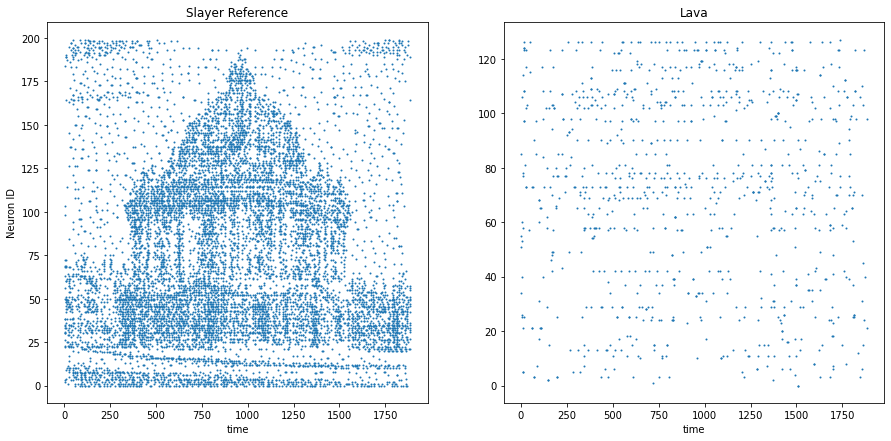

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(gt_event.t, gt_event.x, '.', markersize=2)
ax[1].plot(out_event.t, out_event.x, '.', markersize=2)
ax[0].set_title('Slayer Reference')
ax[0].set_ylabel('Neuron ID')
ax[0].set_xlabel('time')
ax[1].set_title('Lava')
ax[1].set_xlabel('time')